# Deep Ensembles for 1D Regression Problem

This notebook is based on the deep ensembles method, presented in the paper:

[Simple and Scaleable Predictive Uncertainty Estimation](https://proceedings.neurips.cc/paper/2017/hash/9ef2ed4b7fd2c810847ffa5fa85bce38-Abstract.html)

It goes through how to get uncertainties with a simple NN in a regression setting.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plot_point_results(toy, outputs):
    xs = np.linspace(-6,6,200)
    ys = np.power(xs,3)
    plt.plot(xs, outputs, color='g', label="Predictions")
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Point Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_results(toy, outputs, output_variances):
    xs = np.linspace(-6,6,100)
    ys = np.power(xs,3)
    plt.scatter(toy[0],toy[1], color='r', label='Training Samples')
    plt.fill_between(xs, outputs+output_variances, outputs-output_variances, alpha=.5, label="3 $\sigma$ uncertainty envelope")
    plt.legend(loc='best')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Ground Truth and Uncertainty Estimates")
    plt.plot(xs,ys)
    plt.show()

def plot_loss(loss):
    plt.plot(np.arange(len(loss)), loss)
    plt.show()

### Introduction

The main idea of deep ensembles involves training NNs with two targets (mean and variance) rather than just a point-estimate of the mean, and using a proper scoring rule (such as a full likelihood) as the loss function rather than MSE. A proper scoring rule can take many forms, but the basic idea is to measure the quality of predictive uncertainty. 
A few NNs are trained with different initialized state, and thereafter averaged to obtain the final outputs.

### Toy dataset


Following the deep ensemble paper we will setup the problem of estimating predictive variance and evaluate the performance of the proposed method using a one-dimensional toy regression dataset. 

The toy dataset consists of 20 examples sampled from $Y = X^3 + \epsilon$, where $X \sim \text{Uniform}(-4,4)$ and $\epsilon \sim \mathcal{N}(0, 9)$. 


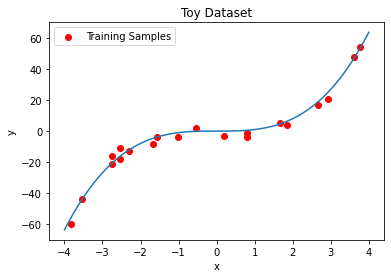

In [2]:
np.random.seed(42)

def draw_examples(n):
    x = np.random.uniform(-4,4, n)
    eps = np.random.normal(0, 3, n)
    y = np.power(x,3) + eps 
    return(x,y)

toy_dataset = draw_examples(20)
inputs, labels = toy_dataset

xs = np.linspace(-4,4,200)
ys = np.power(xs,3)
plt.plot(xs,ys)
plt.scatter(toy_dataset[0],toy_dataset[1], color='r', label='Training Samples')
plt.legend(loc='best')
plt.ylabel("y")
plt.xlabel("x")
plt.title("Toy Dataset")
plt.show()

We follow the model architectures used in the paper. For both the single neural net models and the Deep Ensemble models, we use:
1. A single layer with 100 hidden units and a ReLU activation function
2. ADAM optimizer with learning rate of 0.1
3. 40 epochs for training
4. 5 independently trained neural nets, when using ensembles


#### Single NN

We build a single NN  to fit the toy dataset. We then plot the function $y = x^3$, the 20 training samples, and the predictions  between x = -6 to x = 6. 


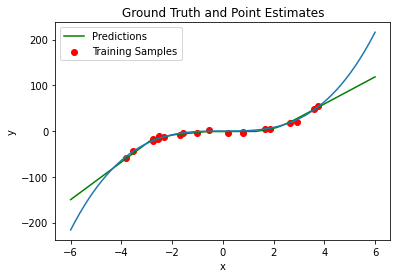

In [3]:
class SingleNet(nn.Module):
    def __init__(self):
        super(SingleNet, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

model = SingleNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
    
        optimizer.zero_grad()

        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

# plot results
xs = np.linspace(-6,6,200)
outputs = [model(torch.tensor([x], dtype=torch.float)) for x in xs]
outputs = np.hstack(torch.stack(outputs).detach().numpy())
plot_point_results(toy_dataset, outputs)

So we see:
* model is good at predicting at values where we have data. In this case, this is between points $x \in [-4, 4]$. However, the model is not good at extrapolating
* we do not have any metric to gauge our confidence in the predictions.

#### Ensembles of NNs


Next, we train multiple neural nets independently and then estimate the uncertainty by using the empirical variance of the estimates:

$$ \mu_*(\mathbf{x}) = \frac{1}{M} \sum_{m=1}^M \mu_{\theta_m}(\mathbf{x})$$
$$ \sigma_*^2(\mathbf{x}) = \frac{1}{M}\sum_{m=1}^M(\mu_{\theta_m}(\mathbf{x}) - \overline{\mu}_{\theta_m}(\mathbf{x}))^2$$


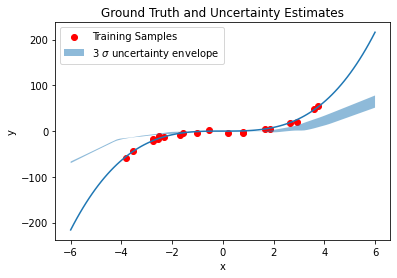

In [4]:
criterion = nn.MSELoss()

n = 5
models = []
for i in range(n):
    model = SingleNet()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    models.append((model, optimizer))
    
# Train each net
def train_model(model, optimizer):
    running_loss = []
    for epoch in range(40):
        epoch_loss = 0
        for x, y in zip(inputs, labels):

            x = torch.tensor([x], dtype = torch.float)
            y = torch.tensor([y], dtype = torch.float)

            optimizer.zero_grad()

            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        running_loss.append(epoch_loss/len(inputs))
        
    xs = np.linspace(-4, 4, 100)
    outputs = [model(torch.tensor([x], dtype=torch.float)) for x in xs]
    outputs = np.hstack(torch.stack(outputs).detach().numpy())
    
    return (running_loss, outputs)



outputs = []
for model, opt in models:
    loss, output = train_model(model, opt)
    outputs.append(output)
    
outputs = np.vstack(outputs)
ys = np.mean(outputs, axis = 0)
stds = 3 * np.std(outputs, axis = 0)

plot_results(toy_dataset, ys, stds)

Comment!

#### Single NN + proper scoring rule


We now train our data on the proper scoring rule, as proposed by the paper. While the standard neural net has a single output (the prediction) and uses a Mean Squared Error (MSE) criterion, this model will have two outputs in the final layer: the mean prediction and a variance estimate, making it a probabilistic neural net. The proper scoring rule used in the paper assumes the observation is a sample generated from a (heteroscedastic) Gaussian distribution, and it minimizes the Negative Log-Likelihood (NLL) criterion: 
$$ -\log{p_{\theta}(y_n \bigm| \mathbf{x}_n)} = \frac{\log{(\sigma^2_{\theta}(\mathbf{x}))}}{2} + \frac{(y - \mu_{\theta}(\mathbf{x}))^2}{2\sigma^2_{\theta}(\mathbf{x})}$$



This criterion forces our model to optimize for both the accuracy of its prediction and its uncertainty estimates. To understand how the function achieves this, consider the edge cases. If our prediction is completely accurate, $y =  \mu_\theta(\mathbf{x})$, rendering the right term 0 and so this function will minimize the variance estimate, $\sigma^2_{\theta}$. If our prediction is very inaccurate, $|y - \mu_\theta(\mathbf{x})| >> 0$, so the second term in the equation causes the loss criterion to make $\sigma^2_{\theta}$ larger. This optimization makes intuitive sense because we want to predict a low variance (conveying high confidence) when our prediction is accurate and predict a high variance (conveying low confidence) when our prediction is inaccurate.

We use the same architecture but with two outputs, and we change our loss function to this  NLL proper scoring rule. To enforce the constraint that the variance output must be positive, we pass it through the Softplus function and add a minimum variance of $10^{-6}$.


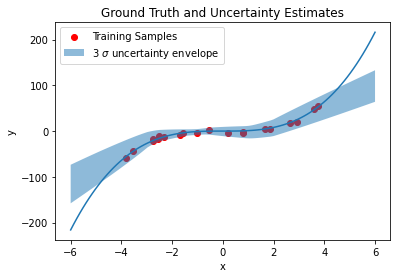

In [5]:
class SingleNet(nn.Module):
    def __init__(self):
        super(SingleNet, self).__init__()
        self.l1 = nn.Linear(1, 100)
        self.l2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

model = SingleNet()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Proper scoring rule using negative log likelihood scoring rule
nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()


running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
    
        optimizer.zero_grad()

        output = model(x)
        mu, sig = output[0], sp(output[1])+(10)**-6
        loss = nll_criterion(mu, sig, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

xs = np.linspace(-6, 6, 100)

mu_outputs = [model(torch.tensor([x],dtype=torch.float))[0] for x in xs]
mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())

sig_outputs = [model(torch.tensor([x], dtype=torch.float))[1] for x in xs]
sig_outputs = np.sqrt(np.hstack(torch.stack(sig_outputs).detach().numpy()))*3

plot_results(toy_dataset, mu_outputs, sig_outputs)


Better, but no cigar yet.

#### Single Neural Network + Proper scoring rule + adversarial training

Next, we tack on the method of *adversarial* training to our training process. Adversarial training involves modifying the training inputs slightly so as to be visually indistinguishable from the training examples but modified in such a way as to make the model worse at predicting their associated labels. Training using these adversarial examples makes the model more robust since it learns even more on points where it would perform badly. Additionally, adversarial training helps smooth the predictive distribution because it increases the likelihood of the model predicting the training value in an $\epsilon$ region around the training point. Generating adversarial examples involves moving the inputs approximately in the direction of steepest ascent. 

In our particular case, we use the fast gradient sign method to create adversarial examples. This entails creating a new 
$$x’ = x + \epsilon\ \text{sign}(\nabla_x \ell(\theta, x,y))$$
where $\epsilon = 0.01 \times \text{range}(x)$ and evaluating $\text{range}(x)$ as the range of the training data along each dimension. We then train the model on both $x$ and $x’$ as two separate data points.


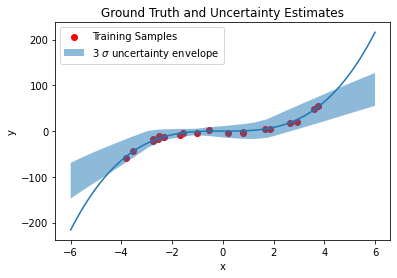

In [6]:
model = SingleNet()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Proper scoring rule using negative log likelihood scoring rule

nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()

eps = 0.01*8
running_loss = []
for epoch in range(40):
    epoch_loss = 0
    for x, y in zip(inputs, labels):
        
        x = torch.tensor([x], dtype = torch.float, requires_grad=True)
        y = torch.tensor([y], dtype = torch.float)
    
        optimizer.zero_grad()

        output = model(x)
        mu, sig = output[0], sp(output[1])+(10)**-6 
        loss = nll_criterion(mu, sig, y)
        loss.backward(retain_graph=True)

        x_a = x + eps*(torch.sign(x.grad.data))
        optimizer.zero_grad()
        
        output_a = model(x_a)
        mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6 # add small number so we don't divide by zero

        # Compute loss as sum of l(x) + l(x')
        loss = nll_criterion(mu, sig, y) + nll_criterion(mu_a, sig_a, y)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        
    running_loss.append(epoch_loss/len(inputs))

xs = np.linspace(-6, 6, 100)

mu_outputs = [model(torch.tensor([x], dtype=torch.float))[0] for x in xs]
mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())

sig_outputs = [model(torch.tensor([x],dtype=torch.float))[1] for x in xs]
sig_outputs = np.sqrt(np.hstack(torch.stack(sig_outputs).detach().numpy()))*3

plot_results(toy_dataset, mu_outputs, sig_outputs)

#### Ensemble + Proper Scoring Rule + Adversarial Training
proper scoring: full log likelihood instead of MSE loss

Finally, we combine all of the methods described above, and train 5 independent probabilistic neural nets using the proper scoring rule and adversarial training. Then, we combine their predictions as an ensemble. Since each neural net now has two outputs (unlike in the original ensemble case), we need a more nuanced method of combining the resulting predictions. This method is to set
$$ \mu_{*}(\mathbf{x}) = \frac{1}{M}\sum_{m=1}^M\mu_{\theta_m}(\mathbf{x})$$
$$\sigma_{*}^2 = \frac{1}{M}\sum_{m=1}^M(\sigma_{\theta_m}^2(\mathbf{x}) + \mu_{\theta_m}(\mathbf{x})) - \mu_{*}^2(\mathbf{x})$$

where M is the number of NNs in the ensemble.





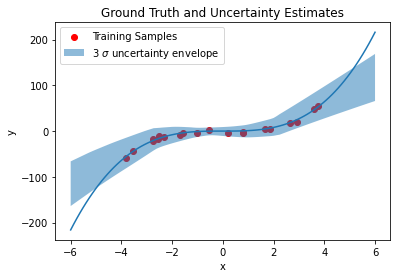

In [7]:
# Proper scoring rule using negative log likelihood scoring rule
nll_criterion = lambda mu, sigma, y: torch.log(sigma)/2 + ((y-mu)**2)/(2*sigma)
sp = torch.nn.Softplus()

# Create 5 neural nets
M = 5
models = []
for i in range(M):
    model = SingleNet()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    models.append((model, optimizer))

# Train function
def train_model(model, optimizer):
    eps = .01*8
    alpha = .5
    running_loss = []
    for epoch in range(40):
        epoch_loss = 0
        for x, y in zip(inputs, labels):

            x = torch.tensor([x], dtype = torch.float, requires_grad=True)
            y = torch.tensor([y], dtype = torch.float)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(x)
            mu, sig = output[0], sp(output[1])+(10)**-6
            loss = nll_criterion(mu, sig, y)
            loss.backward(retain_graph=True)

            x_a = x + eps*(torch.sign(x.grad.data))
            optimizer.zero_grad()

            output_a = model(x_a)
            mu_a, sig_a = output_a[0], sp(output_a[1])+(10)**-6

            loss = alpha*nll_criterion(mu, sig, y) + (1-alpha)*nll_criterion(mu_a, sig_a, y)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

        running_loss.append(epoch_loss/len(inputs))

    xs = np.linspace(-6, 6, 100)

    mu_outputs = [model(torch.tensor([x], dtype=torch.float))[0] for x in xs]
    mu_outputs = np.hstack(torch.stack(mu_outputs).detach().numpy())
    
    sig_outputs = [model(torch.tensor([x], dtype=torch.float))[1] for x in xs]
    sig_outputs = np.hstack(torch.stack(sig_outputs).detach().numpy())
    
    return(running_loss, mu_outputs, sig_outputs)

# Generate predictions for each net
mus = []
sigs = []
for model, opt in models:
    loss, mu, sig = train_model(model, opt)
    mus.append(mu)
    sigs.append(sig)

# Combine the outputs using the criteria explained above
mus = np.vstack(mus)
mu_stars = np.mean(mus, axis = 0)
sigs = np.vstack(sigs)

var_stars = np.mean(np.power(mus, 2) + sigs, axis = 0) - np.power(mu_stars, 2)
sig_3 = np.sqrt(var_stars)*3
plot_results(toy_dataset, mu_stars, sig_3)


Much better!!

### Application:


1. Implement the previous models to a real case of a regression problem.
For example, the infamous Boston housing. An example of a dataset is below. You could take a simple ANN with 50 hidden layers as in the Deep ensembles paper.

2. Better: use your own tabular data!

3. Harder: you can change the distributional output to be a mixture of Gaussians. Such a network is called a Mixture Density Network (MDN). In this case, the average predictions will have to be slightly more complicated than in the single Gaussian case.


In [8]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

import torch.utils.data

class BostonDataset(torch.utils.data.Dataset):

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

X, y = load_boston(return_X_y=True)

dataset = BostonDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

### YOUR CODE!

ImportError: ignored